In [ ]:
!python -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple


In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleGAN.git

Cloning into 'PaddleGAN'...
remote: Enumerating objects: 3755, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 3755 (delta 11), reused 14 (delta 4), pack-reused 3716
Receiving objects: 100% (3755/3755), 161.23 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (2370/2370), done.


In [ ]:
import os
import random
import paddle
import paddle.nn as nn

import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
demo_dataset=paddle.vision.datasets.MNIST(mode='train')

In [ ]:
demo_dataset[0][0]

In [ ]:
dataset=paddle.vision.datasets.MNIST(mode='train',
                  transform=transforms.Compose([
                      transforms.Resize((32,32)),
                      transforms.Normalize([127.5],[127.5])
                                                 
                  ]))
                      

In [ ]:
dataloader=paddle.io.DataLoader(dataset,batch_size=32,shuffle=True,num_workers=4)

In [ ]:
for data in dataloader:
  break

data[0].shape

[32, 1, 32, 32]

In [ ]:
@paddle.no_grad()
def normal_(x,mean=0.,std=1.):
  temp_value=paddle.normal(mean,std,shape=x.shape)
  x.set_value(temp_value)
  return x
  
@paddle.no_grad()
def iniform_(x,a=-1.,b=1.):
  temp_value=paddle.uniform(min=a,max=b,shape=x.shape)
  x.set_value(temp_value)
  return x

@paddle.no_grad()
def constant_(x,value):
  temp_value=paddle.full(x.shape,value,x.dtype)
  x.set_value(temp_value)
  return x


def weights_init(m):
  classname=m.__class__.__name__
  if hasattr(m,'weight')and classname.find('Conv')!=-1:
    normal_(m.weight,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    normal_(m.weight,1.0,0.02)
    constant_(m.bias,0)


In [ ]:
class Generator(nn.Layer):
  def __init__(self, ):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
        nn.Conv2DTranspose(100,64*4,4,1,0,bias_attr=False),
        nn.BatchNorm2D(64*4),
        nn.ReLU(True),

        nn.Conv2DTranspose(64*4,64*2,4,2,1,bias_attr=False),
        nn.BatchNorm2D(64*2),
        nn.ReLU(True),

        nn.Conv2DTranspose(64*2,64,4,2,1,bias_attr=False),
        nn.BatchNorm2D(64),
        nn.ReLU(True),

        nn.Conv2DTranspose(64,1,4,2,1,bias_attr=False),
        nn.Tanh()


    )
  def forward(self,x):
    return self.gen(x)

netG=Generator()
netG.apply(weights_init)

print(netG)




Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Layer):
  def __init__(self, ):
    super(Discriminator,self).__init__()
    self.dis=nn.Sequential(
        nn.Conv2D(1,64,4,2,1,bias_attr=False),
        nn.LeakyReLU(0.2),

        nn.Conv2D(64,64*2,4,2,1,bias_attr=False),
        nn.BatchNorm2D(64*2),
        nn.LeakyReLU(0.2),

        nn.Conv2D(64*2,64*4,4,2,1,bias_attr=False),
        nn.BatchNorm2D(64*4),
        nn.LeakyReLU(0.2),

        nn.Conv2D(64*4,1,4,1,0,bias_attr=False),
        nn.Sigmoid()



    )
  def forward(self,x):
    return self.dis(x)
    
netD=Discriminator()
netD.apply(weights_init)
print(netD)



Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
    (9): Sigmoid()
  )
)


In [ ]:
loss=nn.BCELoss()
fixed_noise=paddle.randn([32,100,1,1],dtype='float32')
#标签，真实样本设为1
real_label=1.
fake_label=0.

#优化器，每个优化器优化其中一个网络结构的参数
optimizerD=optim.Adam(parameters=netD.parameters(),learning_rate=0.0002,beta1=0.5,beta2=0.999)
optimizerG=optim.Adam(parameters=netG.parameters(),learning_rate=0.0002,beta1=0.5,beta2=0.999)



In [ ]:
bs_size

32

In [31]:
!mkdir work

/usr/local/lib/python3.7/dist-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


Epoch ID=0 Batch ID=0 

 D-Loss=0.6199130415916443 G-Loss=4.968353748321533


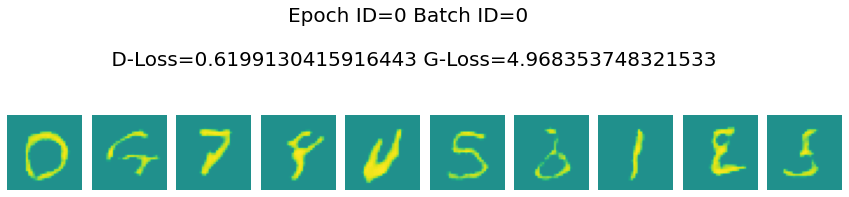

Epoch ID=0 Batch ID=100 

 D-Loss=0.24086979031562805 G-Loss=2.8531622886657715


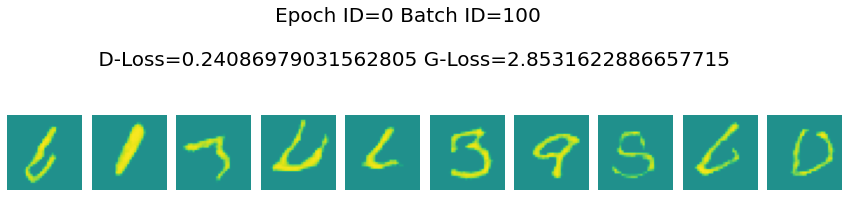

Epoch ID=0 Batch ID=200 

 D-Loss=0.4167623519897461 G-Loss=2.819507598876953


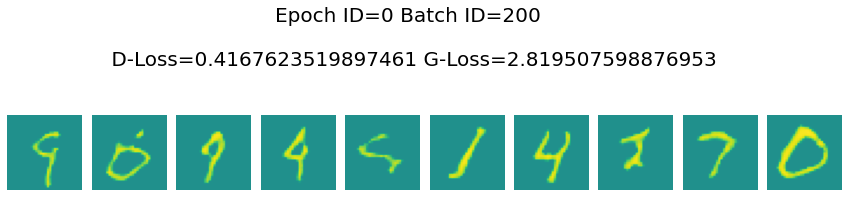

KeyboardInterrupt: ignored

In [33]:
losses=[[],[]]
now=0
for pass_id in range(100):
  for batch_id,(data,target) in enumerate(dataloader):
    #########################################
    #(1) 更新 判别器D网络 maximize log(D(x))+log(1-D(G(z)))
    #########################################

    optimizerD.clear_grad()
    real_img=data
    bs_size=real_img.shape[0]
    label=paddle.full((bs_size,1,1,1),real_label,dtype='float32')
    real_out=netD(real_img)
    errD_real=loss(real_out,label)
    errD_real.backward()

    noise=paddle.randn([bs_size,100,1,1],'float32')
    fake_img=netG(noise)
    label=paddle.full((bs_size,1,1,1),fake_label,dtype='float32')
    fake_out=netD(fake_img.detach())
    errD_fake=loss(fake_out,label)
    errD_fake.backward()
    optimizerD.step()
    optimizerD.clear_grad()

    errD=errD_real+errD_fake
    losses[0].append(errD.numpy()[0])



    ###############################################
    #更新生成器G网络 maximize log(D(G(z)))
    ###############################################
    optimizerG.clear_grad()
    noise=paddle.randn([bs_size,100,1,1],'float32')
    fake=netG(noise)
    label=paddle.full((bs_size,1,1,1),real_label,dtype=np.float32,)
    output=netD(fake)
    errG=loss(output,label)
    errG.backward()
    optimizerG.step()
    optimizerG.clear_grad()

    losses[1].append(errG.numpy()[0])

    #############################
    #可视化
    #############################
    if batch_id % 100==0:
      generated_image=netG(noise).numpy()
      imgs=[]
      plt.figure(figsize=(15,15))
      try:
        for i in range(10):
          image=generated_image[i].transpose()
          image=np.where(image>0,image,0)
          image=image.transpose((1,0,2))
          plt.subplot(10,10,i+1)

          plt.imshow(image[...,0],vmin=-1,vmax=1)
          plt.axis('off')
          plt.xticks([])
          plt.yticks([])
          plt.subplots_adjust(wspace=0.1,hspace=0.1)
        msg='Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id,batch_id,errD.numpy()[0],errG.numpy()[0])
        print(msg)
        plt.suptitle(msg,fontsize=20)
        plt.draw()
        plt.savefig('{}/{:04d}_{:04d}.png'.format('work',pass_id,batch_id))
        plt.pause(0.01)
      except IOError:
        print(IOError)
  paddle.save(netG.state_dict(),"work/generator.params")
